# De-trending and modelling seasonal variation with Fourier Series

<b> YouTube Tutorial </b> (Published: Jul 13, 2022): https://youtu.be/sa7E9qUHYXw

Time series decomposition is a technique that splits a time series into several components, each representing an underlying pattern category, trend, seasonality, and noise.

1. Trend: decreasing, constant, or increasing over time?
2. Seasonality: what is the periodic signal?
3. Noise: variability in the data that cannot be explained by the model

$\large y_t = T_t + S_t + e_t$

The model (in terms of T for temperature) for deterministic seasonal mean temperature : $\large \bar{T_t}= T_{trend} + T_{seasonal}$

The DATA from pervious tutorials:

In [ ]:
import os
import numpy as np
import pandas as pd
import datetime as dt
from scipy import signal
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

dir_path = os.path.dirname(os.path.realpath('__file__'))
data_folder = os.path.join(dir_path, 'statistical analysis')
max_temp = pd.read_csv('https://raw.githubusercontent.com/ASXPortfolio/jupyter-notebooks-data/main/maximum_temperature.csv')
min_temp = pd.read_csv('https://raw.githubusercontent.com/ASXPortfolio/jupyter-notebooks-data/main/minimum_temperature.csv')

def datetime(row):
    return dt.datetime(row.Year,row.Month,row.Day)

max_temp['Date'] = max_temp.apply(datetime,axis=1)
min_temp['Date'] = min_temp.apply(datetime,axis=1)
max_temp.set_index('Date', inplace=True)
min_temp.set_index('Date', inplace=True)
drop_cols = [0,1,2,3,4,6,7]
max_temp.drop(max_temp.columns[drop_cols],axis=1,inplace=True)
min_temp.drop(min_temp.columns[drop_cols],axis=1,inplace=True)
max_temp.rename(columns={'Maximum temperature (Degree C)':'Tmax'}, inplace=True)
min_temp.rename(columns={'Minimum temperature (Degree C)':'Tmin'}, inplace=True)

temps = max_temp.merge(min_temp,how='inner',left_on=['Date'],right_on=['Date'])

def avg_temp(row):
    return (row.Tmax+row.Tmin)/2

temps['T'] = temps.apply(avg_temp,axis=1)

# drop na values here
temps = temps.dropna()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Daily Average Temperature Series from Sydney Observatory

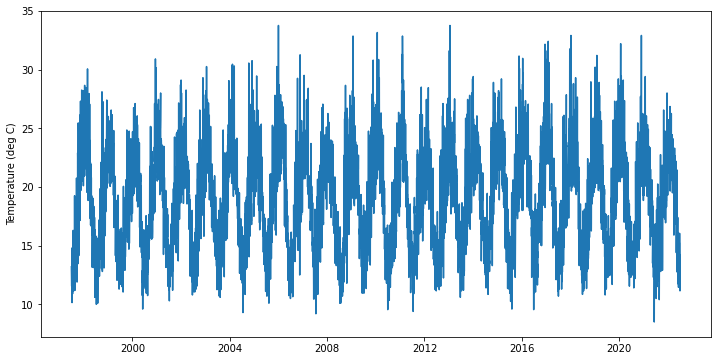

In [ ]:
lookback = 365*25
fig = plt.figure(figsize=(12,6))
plt.plot(temps['T'][-lookback:])
plt.ylabel('Temperature (deg C)')
plt.show()

## Denoised Series

Let's remove the noise to see trend and overall peaks.

We will use a simple algorithm that is used frequently in the signal processing industry, Convolutions.
A convolution is a mathematical operation which generates a new function that is a function of two prior functions, meaning the convolution is the area under the curve of the two functions which are moved towards and away from one another ('convolved').

$\large (f * g)(x) = \int^{\infty}_{-\infty} f(\tau)g(x−\tau)d\tau$

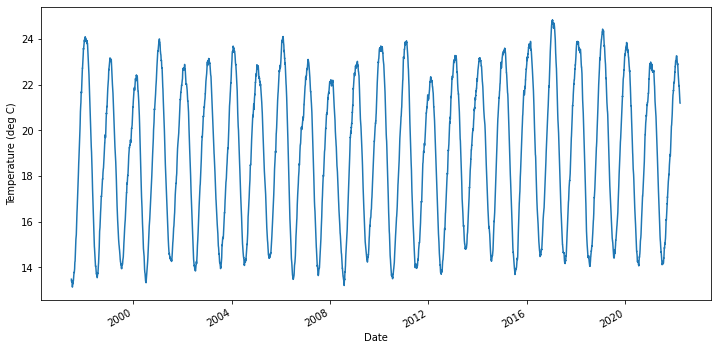

In [ ]:
def apply_convolution(x, window):
    conv = np.repeat([0., 1., 0.], window)
    filtered = signal.convolve(x, conv, mode='same') / window
    return filtered

denoised = temps.apply(lambda x: apply_convolution(x, 90))
denoised['T'][-lookback:-100].plot(figsize=(12,6))
plt.ylabel('Temperature (deg C)')
plt.show()

## Longterm Trends

By observing the rolling moving average over time, we noticed that there is a clear but weak trend over time.  

Therefore we will simply use the following linear function.

$\Large T_{linear} = a + bt$

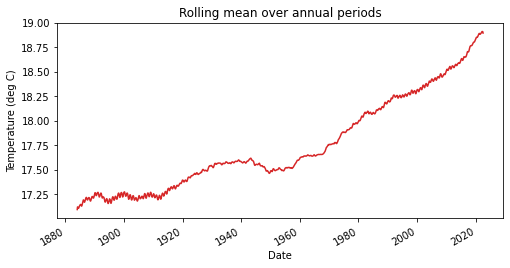

In [ ]:
denoised['MA'] = denoised['T'].rolling(window = lookback).mean()
plt.ylabel('Temperature (deg C)')
denoised['MA'].plot(figsize=(8,4), color="tab:red", title="Rolling mean over annual periods")

## Seasonal Variation

The <i>denoised</i> temperature time series reveals that temperatures have somewhat uniform peaks.

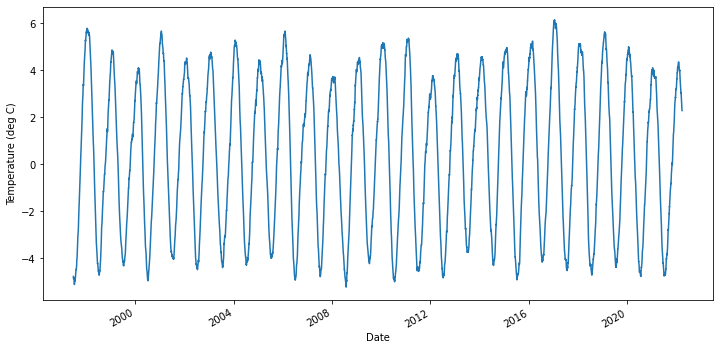

In [ ]:
denoised['S'] = denoised['T'] - denoised['MA']
denoised['S'][-lookback:-100].plot(figsize=(12,6))
plt.ylabel('Temperature (deg C)')
plt.show()

We will model the seasonal variation via a truncated Fourier series of form:

$\large T_{seasonal} = a_0 + \sum_i \alpha_i sin(i \omega_1 t + \theta) + \sum_i \beta_i cos(i \omega_2 t + \phi)$

The good news is that many papers suggest that the temperature seasonal variation can be captured by the first order Fourier series.

$\large T_{seasonal} = \alpha sin(\omega t + \theta) + \beta cos(\omega t + \phi)$

The following papers has even used a simplification of a single sine function: (we will compare the two)

$\large T_{seasonal} = \alpha sin(\omega t + \theta)$

$\large T_{seasonal} = \alpha sin(\theta) cos(\omega t) + \alpha cos(\theta) sin(\omega t)$

Defining $\large a_1 = \alpha sin(\theta)$  and $\large b_1 = \alpha cos(\theta)$, we can rewrite this as:

$\large T_{seasonal} = a_1 cos(\omega t) + b_1 sin(\omega t)$

where
- $\large \alpha = \sqrt{a_1^2+b_1^2}$
- and because $\large tan(\theta) = \frac{a_1}{b_1}$: $\large \theta = tan^{-1}(\frac{a_1}{b_1})$

Notice that we assume:
- $a_0$ will be captured in the trend component
- the <i>speeds</i> of the seasonal processes are the same at $\large \omega = \frac{2\pi}{365.25}$

# De-trended & Seasonality Removed

So the deterministic seasonal mean, the denoised time series is modelled like:
    
$\large \bar{T_t}= T_{trend} + T_{seasonal}$

Test and compare two models:

1. $\large \bar{T_t} = a + bt + \alpha sin(\omega t + \theta) + \beta cos(\omega t + \phi)$
2. $\large \bar{T_t} = a + bt + \alpha sin(\omega t + \theta)$

If you want to compare non-linear model fits, check out this [link](https://stackoverflow.com/questions/23004374/how-to-calculate-the-likelihood-of-curve-fitting-in-scipy).

## Model Fitting: Non-linear Least Squares!

Here we use scipy.optimize.curve_fit which implements the Levenberg-Marquardt algorithm (LMA).

This is used in non-linear least squares problems and combines both the Gauss-Newton algorithm (GNA) and gradient descent methods.

$\Large \hat{\beta} \in argmin_\beta S(\beta) \equiv argmin_\beta \sum_{i-1}^N \left[ y_i - f(x_i, \beta) \right]^2$

In [ ]:
from scipy.stats import norm
from scipy.optimize import curve_fit

In [ ]:
temp_t = temps['T'].copy(deep=True)
temp_t = temp_t.to_frame()

In [ ]:
def model_fit_general(x, a, b, a1, b1, theta, phi):
    omega = 2*np.pi/365 #365.25
    y_pred = a + b*x + a1*np.cos(omega*x + theta) + b1*np.sin(omega*x + phi)
    return y_pred

def model_fit(x, a, b, a1, b1):
    omega = 2*np.pi/365 #365.25
    y_pred = a + b*x + a1*np.cos(omega*x) + b1*np.sin(omega*x)
    return y_pred

def RSS(y, y_pred):
    return np.sqrt( (y - y_pred)**2 ).sum()

In [ ]:
if isinstance(temp_t.index , pd.DatetimeIndex):
    first_ord = temp_t.index.map(dt.datetime.toordinal)[0]
    temp_t.index=temp_t.index.map(dt.datetime.toordinal)

params, cov = curve_fit(model_fit, xdata = temp_t.index-first_ord, ydata = temp_t['T'], method='lm')

param_list = ['a', 'b', 'a1', 'b1']

print('\n Model 1 \n')
std_dev = np.sqrt(np.diag(cov))
for name, p, sd in zip( param_list, params, std_dev):
    print('{0} :  {1:0.3}  CI ~normally [{2:0.2e},{3:0.2e}]'.format(name, p, p-1.96*sd,p+1.96*sd))

temp_t['model_fit'] = model_fit(temp_t.index-first_ord, *params)

if isinstance(temp_t.index , pd.DatetimeIndex):
    temp_t.index=temp_t.index.map(dt.datetime.toordinal)
params1, cov1 = curve_fit(model_fit_general, xdata = temp_t.index-first_ord, ydata = temp_t['T'], method='lm')

param_list = ['a', 'b', 'a1', 'b1', 'theta', 'phi']

print('\n Model 1 \n')
std_dev = np.sqrt(np.diag(cov1))
for name, p, sd in zip( param_list, params1, std_dev):
    print('{0} :  {1:0.3}  CI ~normally [{2:0.2e},{3:0.2e}]'.format(name, p, p-1.96*sd,p+1.96*sd))

temp_t['model_fit_general'] = model_fit_general(temp_t.index-first_ord, *params1)


 Model 1 

a :  16.8  CI ~normally [1.68e+01,1.68e+01]
b :  3.35e-05  CI ~normally [3.23e-05,3.46e-05]
a1 :  3.92  CI ~normally [3.89e+00,3.95e+00]
b1 :  3.0  CI ~normally [2.97e+00,3.02e+00]

 Model 1 

a :  16.8  CI ~normally [1.68e+01,1.68e+01]
b :  3.35e-05  CI ~normally [3.23e-05,3.46e-05]
a1 :  -1.74e+02  CI ~normally [nan,nan]
b1 :  1.7e+02  CI ~normally [nan,nan]
theta :  1.04e+02  CI ~normally [-6.27e+03,6.48e+03]
phi :  2.18e+02  CI ~normally [-5.20e+03,5.63e+03]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt


Residual Sum of Squares (RSS)
  RSS model generalised: 112295.81
  RSS model sine curve : 112295.89


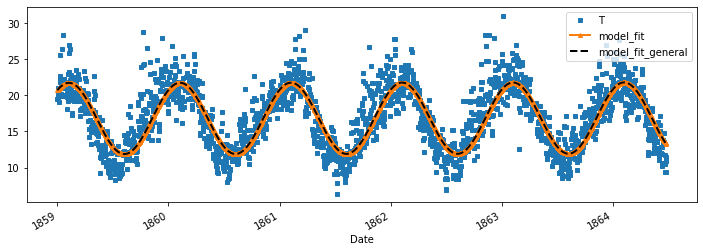

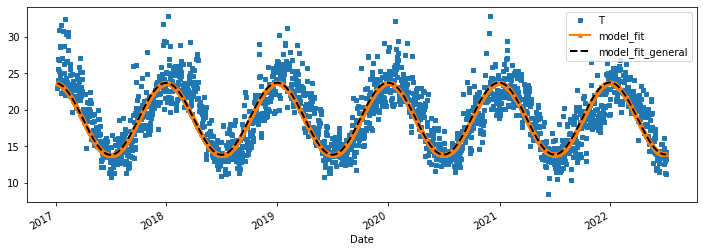

In [ ]:
if not isinstance(temp_t.index , pd.DatetimeIndex):
    temp_t.index=temp_t.index.map(dt.datetime.fromordinal)

temp_t[:2000].plot(figsize=(12,4), style=['s','^-','k--'] , markersize=4, linewidth=2 )
temp_t[-2000:].plot(figsize=(12,4), style=['s','^-','k--'] , markersize=4, linewidth=2 )

RSS(temp_t['T'], temp_t['model_fit_general'])
print('Residual Sum of Squares (RSS)')
print('  RSS model generalised:', round(RSS(temp_t['T'], temp_t['model_fit_general']),2))
print('  RSS model sine curve :', round(RSS(temp_t['T'], temp_t['model_fit']),2))

Both models are equivalent, so we choose the simple one with less tuned parameters. Aiming for parsimony. There does seems to be an issue with the leading and lagging phase shifts between the 160 year intervals. This was identified as the incorrect frequency assumption of 365 days a year. .25 days over approximately 160 years accounts for a shift of approximately 40 days.

Therefore the speeds of the seasonal processes are the same at $\large \omega=\frac{2 \pi}{365.25}$

In [ ]:
temp_t = temps['T'].copy(deep=True)
temp_t = temp_t.to_frame()

In [ ]:
def model(x, params):
    a,b,a1,b1 = params
    omega = 2*np.pi/365.25 #365.25
    theta = np.arctan(a1/b1)
    alpha = np.sqrt( a1**2 + b1**2)
    print('Parameters:\n     a {0:0.3}\n     b {1:0.3}\n alpha {2:0.3}\n theta {3:0.3}'.format(a,b,alpha,theta))
    y_pred = a + b*x + alpha*np.sin(omega*x + theta)
    return y_pred

def model_fit(x, a, b, a1, b1):
    omega = 2*np.pi/365.25
    y_pred = a + b*x + a1*np.cos(omega*x) + b1*np.sin(omega*x)
    return y_pred

Parameters:
     a 16.8
     b 3.32e-05
 alpha 5.05
 theta 1.27


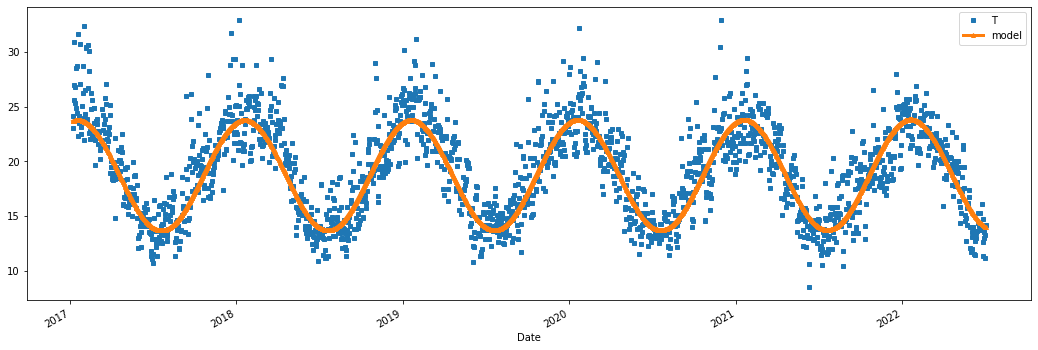

In [ ]:
if isinstance(temp_t.index , pd.DatetimeIndex):
    first_ord = temp_t.index.map(dt.datetime.toordinal)[0]
    temp_t.index=temp_t.index.map(dt.datetime.toordinal)

params_all, cov = curve_fit(model_fit, xdata = temp_t.index-first_ord, ydata = temp_t['T'], method='lm')

temp_t['model'] = model(temp_t.index-first_ord, params_all)
# temp_t['model_fit'] = model_fit(temp_t.index-first_ord, *params)


if not isinstance(temp_t.index , pd.DatetimeIndex):
    temp_t.index=temp_t.index.map(dt.datetime.fromordinal)

temp_t[-2000:].plot(figsize=(18,6), style=['s','^-','k-'] , markersize=4, linewidth=3 )

In [ ]:
temp_t.index[0]

Timestamp('1859-01-01 00:00:00')

## Our Model for the trend and seasonality

This is our changing average of DAT.

$\large \bar{T_t} = a + bt + \alpha sin(\omega t + \theta)$

Where our changing average of DAT $\large \bar{T_t}$ is:

$\large \bar{T_t} = 16.8 + (3.32e-05)t + 5.05 sin((\frac{2\pi}{365.25})t + 1.27)$

Where the date <b>01-Jan 1859</b> corresponds with the first ordinal number 0.

In [ ]:
if isinstance(temp_t.index , pd.DatetimeIndex):
    first_ord = temp_t.index.map(dt.datetime.toordinal)[0]
    temp_t.index=temp_t.index.map(dt.datetime.toordinal)
temp_t['model'] = model(temp_t.index-first_ord, params_all)

Parameters:
     a 16.8
     b 3.32e-05
 alpha 5.05
 theta 1.27


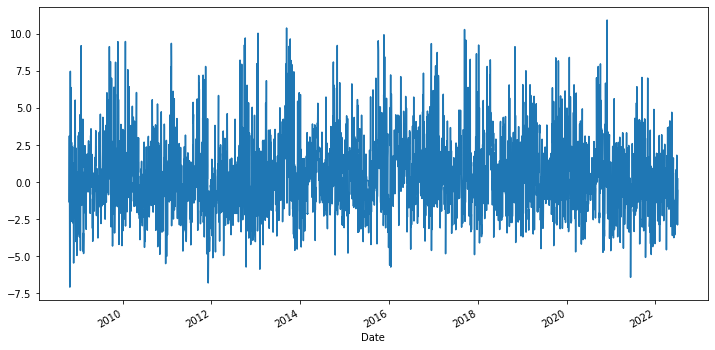

In [ ]:
if not isinstance(temp_t.index , pd.DatetimeIndex):
    temp_t.index=temp_t.index.map(dt.datetime.fromordinal)

temp_t['res'] = temp_t['T']-temp_t['model']
temp_t['res'][-5000:].plot(figsize=(12,6))
plt.show()

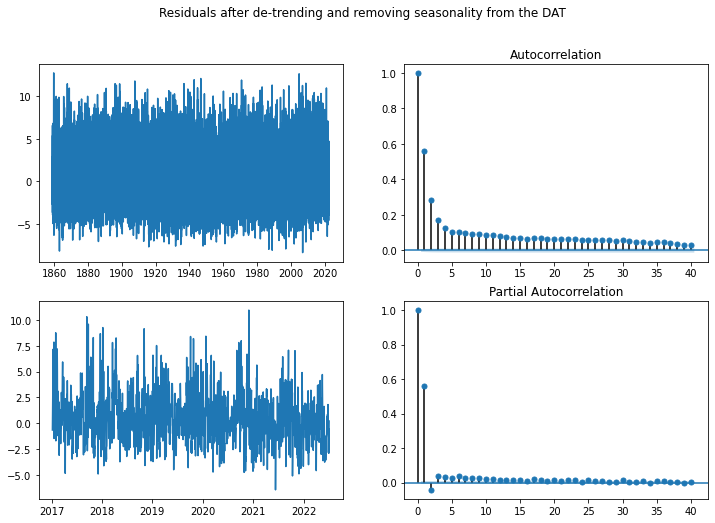

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(12,8))
fig.suptitle('Residuals after de-trending and removing seasonality from the DAT')
axs[0,0].plot(temp_t['res'])
axs[1,0].plot(temp_t['res'][-2000:])
plot_acf(temp_t['res'], lags=40, ax=axs[0,1])
plot_pacf(temp_t['res'], lags=40, ax=axs[1,1])
plt.show()

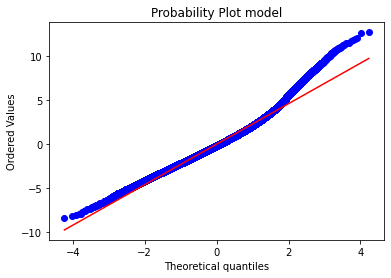

In [ ]:
import scipy.stats as stats
stats.probplot(temp_t['res'], dist="norm", plot=plt)
plt.title("Probability Plot model")
plt.show()

P(Z > 2): 3.59% vs Normal Distibution: 2.28% 
SKEW    : 0.629
KURTOSIS: 4.23


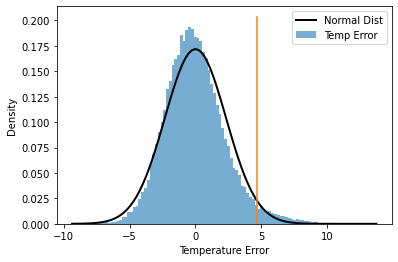

In [ ]:
mu, std = norm.fit(temp_t['res'])
z = (temp_t['res'] - mu)/std
plt.hist(temp_t['res'], density=True, alpha=0.6, bins=100, label='Temp Error')

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
data = np.random.randn(100000)

plt.plot(x, p, 'k', linewidth=2, label='Normal Dist')
plt.plot([std*2,std*2],[0,ymax])

print('P(Z > 2): {:0.3}% vs Normal Distibution: {:0.3}% '.format(len(z[z >= 2])/len(z)*100, (1-norm.cdf(2))*100))
print('SKEW    : {:0.3}'.format(stats.skew(z)))
print('KURTOSIS: {:0.3}'.format(stats.kurtosis(z)+3))
plt.ylabel('Density')
plt.xlabel('Temperature Error')
plt.legend()
plt.show()